Generate blended images
- Read in a set of fits images
- Shift and rotate pairs of these images (at random)
- Combine the images into a blend


In [37]:
#Read in fits image
import astropy.io.fits as fits
from os import listdir
from os.path import isfile, join
import matplotlib.pyplot as plt
from matplotlib import gridspec
import scipy.ndimage
import numpy as np
%matplotlib inline


In [38]:
def plotImageGrid(imageList, fig):
    '''Given a list of images plot them on a grid'''

    nGalaxies = len(imageList)
    nrows = np.int(np.sqrt(nGalaxies) + 1.)
    gs = gridspec.GridSpec(nrows, nrows)

    for i in xrange(nGalaxies):
        ax = fig.add_subplot(gs[i])
        plt.imshow(imageList[i], cmap='gray', vmax=imageList[i].mean() + 2.*imageList[i].std())

In [39]:
import copy
def cutout(image, nx, ny):
    '''Cut out a region nx by ny assuming it is smaller than the image'''
    
    x,y = image.shape
    if (x < nx) or ( y < ny):
        raise("image is smaller than region to cut out")
    padx = x - nx
    pady = y - ny
    
    cutout = image[padx/2:padx/2+nx,pady/2:pady/2+ny]
    return cutout*1.0

def coaddImage(imageList, shiftx, shifty, rotation):
    '''Given a set of images and shifts in x, y rotation combine images
    
    assumes first image is the reference image'''
    
    if (len(imageList)-1 != len(shiftx)) or len(shifty) != len(rotation) or len(shiftx) != len(shifty):
        raise("image list and offsets and rotation are not of equal length")

    #find minimum size of images to define output
    minx = min([image.shape[0] for image in imageList])
    miny = min([image.shape[1] for image in imageList])
    blend = cutout(imageList[0], minx, miny)
    for image, x, y, rot in zip(imageList[1:], shiftx, shifty, rotation):
        #rotate image and then resize and shift
        stamp = scipy.ndimage.interpolation.rotate(image, rot)
        stamp = cutout(stamp, minx, miny)

        blend += scipy.ndimage.interpolation.shift(stamp, [x,y])

    return blend

Number of selected galaxies 50


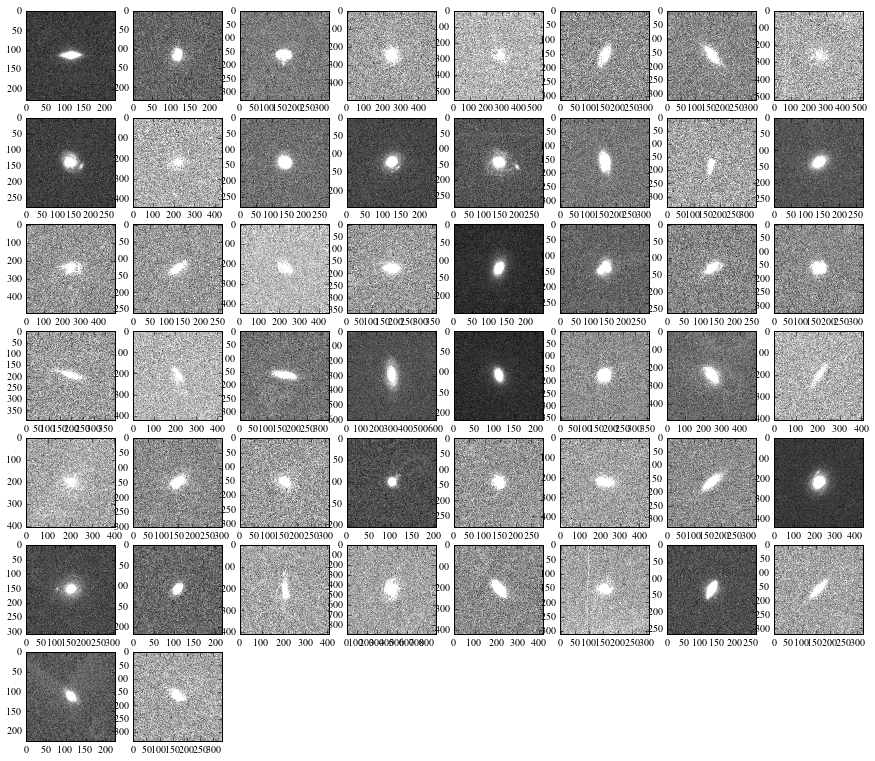

In [40]:
#Select N galaxies to generate deblended images for and plot
Ngalaxy = 50
fileStart = 15

imagepath = 'cosmos_galaxy_postage_stamps'
fitsfiles = [join(imagepath, f) for f in listdir(imagepath) if isfile(join(imagepath, f))]

i=0
imageList = []
for fitsfile in fitsfiles:
    if ('processed' in fitsfile):
        hdulist = fits.open(fitsfile)
        if i > fileStart:
            imageList.append(hdulist[0].data)
        i = i+1
        hdulist.close()
        
        if i>(fileStart+Ngalaxy):
            break
print 'Number of selected galaxies', len(imageList)
fig = plt.figure(figsize=(15,15))
plotImageGrid(imageList, fig)

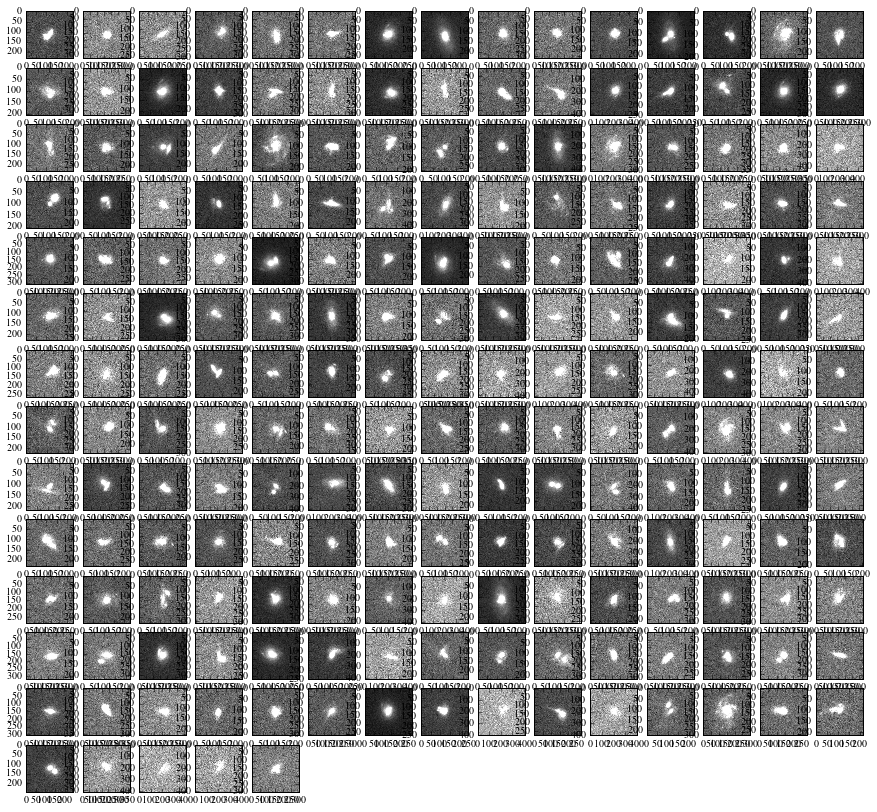

In [41]:
# Given a list of images generate a randomized (nRandom) set of pairs and orientations with a maximum offset (maxShift)
nRandom = 200
maxshift = 30

# Randomly select galaxy pairs and randomly select offsets and rotations
source  = np.random.random_integers(0, high=len(imageList)-1, size=nRandom)
target  = np.random.random_integers(0, high=len(imageList)-1, size=nRandom)

shiftx = maxshift*2.*(np.random.random_sample(size=nRandom)-0.5)
shifty = maxshift*2.*(np.random.random_sample(size=nRandom)-0.5)
rotation = 180.*np.random.random_sample(size=nRandom)


blendList = []
for i in range(nRandom):
        new = coaddImage([imageList[source[i]],imageList[target[i]]], [shiftx[i]], [shifty[i]], [rotation[i]])
        blendList.append(new)


fig = plt.figure(figsize=(15,15))
plotImageGrid(blendList, fig)
